In [59]:
import scipy
import scipy.io
import scipy.integrate
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Activation, Concatenate, Lambda, Multiply, Dot, Add, Subtract
from tensorflow.keras import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from matplotlib.tri import *
import numpy.random as random
import pandas as pd
import seaborn as sns
import time
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"

**Rotation matrices**

Rotation matrix to rotate the stresses of an angle $\theta$

$ R_{\sigma}(\theta) = \begin{bmatrix} cos^2\theta & sin^2\theta & cos\theta sin\theta\\ 
                               sin^2\theta & cos^2\theta & -cos\theta sin\theta\\ 
                               -2cos\theta sin\theta & 2cos\theta sin\theta & cos^2\theta-sin^2\theta\end{bmatrix} $
                               
                              
Rotation matrix to rotate the strains of an angle $\theta$

$ R_{\varepsilon}(\theta) = \begin{bmatrix} cos^2\theta & sin^2\theta & 2cos\theta sin\theta\\ 
                               sin^2\theta & cos^2\theta & -2cos\theta sin\theta\\ 
                               -cos\theta sin\theta & cos\theta sin\theta & cos^2\theta-sin^2\theta\end{bmatrix} $

In [60]:
def rotate_e(xt, theta):
    alpha = np.deg2rad(theta)
    c = np.cos(alpha)
    s = np.sin(alpha)
    x = np.transpose(xt)
    # R = [[1, 0, 0], [0, 1, 0], [0, 0, 2]]
    # Rm = [[1, 0, 0], [0, 1, 0], [0, 0, .5]]
    T = [[  c**2,  s**2,    s*c], 
         [  s**2,  c**2,   -s*c], 
         [-2*s*c, 2*s*c, c**2-s**2]]
    # eps_ = np.transpose(np.matmul(rot, x))
    eps_ = np.transpose(np.matmul(T, x))
    return eps_


def rotate_s(x, theta):
    alpha = np.deg2rad(theta)
    c = np.cos(alpha)
    s = np.sin(alpha)
    # x = np.transpose(xt)
    T = [[c**2, s**2,    2*s*c], 
         [s**2, c**2,   -2*s*c], 
         [-s*c,  s*c,  c**2-s**2]]
    Tinv = np.linalg.inv(T)
    x_ = np.transpose(np.matmul(Tinv, x))
    return x_

The TestData class takes as input the .mat files containing the test results and makes the following operations:

- Compute the number of frames in the data
- Remove the last *remove_frames* frames from the data
- Compute the external force as $\int_{0}^{d} F \,du$
- **Multiply** the internal force by 2 to compare with double internal energy $\int_{\Omega} \varepsilon:\sigma dV$
- Compute the engineering shear strain $\gamma_{12}=2\varepsilon_{12}$ if *shear='true'*
- Rotate the strains of *angle*°

The TestData class can be clustered using *TestData.cluster()* into n_clusters. The function performs the following operations:

- Round the strain values to the 4th decimal digit
- Identify the unique values
- Computes the Principal Component Analysis of the unique values
- Reduce the data dimension from 3 to 2 using the first two principal components
- Performs a KMeans clustering with *n_clusters* centroids
- Assign the centroid values to every point in the cluster
- Project back the values from the principal reference system to the original one

Strain data can be augmented if the material is balanced using the function *TestData.mirror()*

*TestData.prepare(test_split)* divide the dataset into training and validation subset randomly picking *(test_split x n_frames)* frames 

In [61]:
class TestData:
    def __init__(self, folder, filename, remove_frames=0, angle='auto', shear='eng'):
        if filename[-4:] != '.mat':
            filename = filename + '.mat'
        self.name = filename
        self.data = scipy.io.loadmat(folder+'\\'+filename)
        self.nelem = np.squeeze(self.data['nelem']).astype(int)
        self.remove_frames = remove_frames

        self.n_frames = int(self.data['d'].shape[0] - remove_frames)
        self.d = self.data['d'][:self.n_frames]
        self.f = self.data['F'][:self.n_frames]
        self.W = 2*np.abs(scipy.integrate.cumtrapz(self.f, self.d, axis=0, initial=0)) * 10  #Compute 2U
        self.We = np.repeat(self.W, self.nelem, axis=0)
        
        self.eps = np.round(self.data['EPS'][:self.n_frames*self.nelem, :], 3) * 10
        self.eps_raw = np.round(self.data['EPS'][:self.n_frames*self.nelem, :],3) * 10
        if shear == 'true':
            self.eps[:, 2] = 2 * self.eps[:, 2]
            self.eps_raw[:, 2] = 2 * self.eps_raw[:, 2]
            
        self.area = self.data['area']
        self.nodes, self.coordinates = self.data['nodes'], self.data['coordinates']
        
        self.train_data = None
        self.X = self.data['X']
        self.Y = self.data['Y']
        self.kmean = None
        self.labels = None
        self.centers = None
        
        self.theta = 0
        if angle=='auto':
            if filename[0] == 'A':
                angle = 45
            else:
                angle = 0
        else:
            self.angle = angle
        self.rotate(self.angle)

        self.x_test = None
        self.x_train = None
        self.y_train = None
        self.y_test = None
        
#     def reduce_dataset(compression_ratio=):
#         # find mesh points
#         kmean = KMeans(n_clusters=np.round(compression_ratio*self.X.shape[0], 0)
#         kmean.fit(np.array([self.X, self.Y]))
#         self.X = kmean.cluster_centers_[:, 0]
#         self.Y = kmean.cluster_centers_[:, 1]
#         self.
        
        
    def cluster(self, n_clusters):
        x = self.eps_raw
        x[x < 1e-5] = 0
        xu, ic = np.unique(x, return_inverse=True, axis=0)
        print('Finding unique values ..')
        pca = PCA(n_components=2).fit(xu)
        print('Computing Principal Components ..')
        xu_pca = pca.transform(xu)
        print('Clustering ..')
        kmean = KMeans(n_clusters=n_clusters).fit(xu_pca)
        xu_cluster = pca.inverse_transform(kmean.cluster_centers_)[kmean.labels_, :]
        x_clustered = xu_cluster[ic, :]
        self.eps = x_clustered
        self.labels = kmean.labels_[ic]
        self.kmean = kmean
        self.centers = pca.inverse_transform(kmean.cluster_centers_)

    def __str__(self):
        return f"{self.name} has {self.nelem} elements"

    def rotate(self, alpha):
        self.eps = rotate_e(self.eps, alpha)
        self.theta += alpha

    def mirror(self):
        self.eps = np.concatenate((self.eps, rotate_e(self.eps, self.theta - 90)))
        self.We = np.concatenate((self.We, self.We))

    def prepare(self, test_split=0.2):
        test_size = np.round(test_split * self.n_frames).astype(int)
        test_frames = np.sort(
            np.random.choice(
                self.n_frames,
                np.squeeze(test_size), replace=False).astype(int))
        train_frames = np.setdiff1d(np.arange(self.n_frames), test_frames).astype(int)
        x_test = np.zeros((1, self.eps.shape[1]))
        x_train = np.zeros((1, self.eps.shape[1]))
        y_test = np.zeros((1, 1))
        y_train = np.zeros((1, 1))
        for i in np.arange(test_frames.shape[0]):
            x_test = np.append(x_test,
                               self.eps[np.arange(test_frames[i] * self.nelem, test_frames[i] * self.nelem + self.nelem).astype(int), :],
                               axis=0)
            y_test = np.append(y_test,
                               self.We[np.arange(test_frames[i] * self.nelem, test_frames[i] * self.nelem + self.nelem).astype(int),
                               :], axis=0)
        for i in np.arange(train_frames.shape[0]):
            x_train = np.append(x_train,
                                self.eps[np.arange(train_frames[i] * self.nelem, train_frames[i] * self.nelem + self.nelem).astype(int), :],
                                axis=0)
            y_train = np.append(y_train, self.We[
                                         np.arange(train_frames[i] * self.nelem, train_frames[i] * self.nelem + self.nelem).astype(
                                             int), :], axis=0)
        self.x_test = x_test[1:, :]
        self.x_train = x_train[1:, :]
        self.y_train = y_train[1:, :]
        self.y_test = y_test[1:, :]

        print('The real test size is: ' + str(100 * x_test.shape[0] / (x_test.shape[0] + x_train.shape[0])) + ' %')

        return self.x_train, self.x_test, self.y_train, self.y_test

The **pinn_model** class build the PINN model
build_e(n_layers, n_neurons, act_fun, thickness, area) builds the modified NN described in the paper with n_layers with n_neurons each for every material matrix component to be predicted.

$N_{1}(\varepsilon) = \begin{bmatrix} C_{11} \\ C_{22} \end{bmatrix}$,  $N_{2}(\varepsilon) = C_{12}$,  $N_{3}(\varepsilon) = C_{66}$

Stress computation of the $i^{th}$ element at the $k^{th}$ frame:

$\sigma = \begin{bmatrix}
\begin{bmatrix} C_{11} \\ C_{22} \end{bmatrix} \bullet \begin{bmatrix} \varepsilon_{11} \\ \varepsilon_{22} \end{bmatrix} + C_{12} \bullet \begin{bmatrix} \varepsilon_{22} \\ \varepsilon_{11} \end{bmatrix} \\ C_{66}\gamma_{12}
\end{bmatrix}$

Internal energy at the $k^{th}$ frame:

$2U^k = \int_{\Omega}\varepsilon^k\sigma^k dV = t\sum_{i}^{nelem}A_i\varepsilon_i^k\sigma_i^k$

Loss terms at $k^{th}$ epoch corresponding to the $k^{th}$ frame of the training set:
- $\mathcal{L}_{en} = |U^k-W_{ext}^k|$


- $\mathcal{L}_{div} = \sum\limits_{i\in I_{col}}\sum\limits_{k\in K_{col}}|div\bullet\sigma_{i}^{k}|$


- $\mathcal{L}_{bc} = \sum\limits_{i\in I_{bc}}\sum\limits_{k\in K_{col}}|\sigma_i^k\bullet n - F_{bc}^k|$

$K_{col}$ and $I_{col}$ are the co-location points where the loss is computed, while $I_{bc}$ contains the boundary points.


Total loss:

$\mathcal{L}_{tot} = \alpha\mathcal{L}_{en} + \beta\mathcal{L}_{div} + \chi\mathcal{L}_{bc}$


In [97]:
 class pinn_model:
    def __init__(self, norm=False):
        self.net = None
        self.sub_net = None
        self.norm = norm
        self.hist = None
        self.train_data = None
        self.Xscaler = None
        self.Yscaler = None
        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None
        
    def build_short(self, n_layers, n_neurons, act_fun, thickness, area, bayesan=False):
        # Input layer
        strains = Input(shape=(3,), name='strains')
        strains_t = Reshape((1, 3))(strains)

        # Common Hidden layers
        if self.norm:
            # Normalized
            strains_n = Input(shape=(3,), name='strains_n')
            strains_nt = Reshape((1, 3))(strains)
            C = Dense(units=n_neurons, activation=act_fun)(strains_nt)
        else:
            C = Dense(units=n_neurons, activation=act_fun)(strains_t)
            
        for i in range(n_layers):
            C = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(C)
        C = Dense(units=3, activation='relu', name='trCa')(C)
        
        # Compute s1 and s1
        trSa = Multiply()([C[:, :, 0], strains_t[:, :, 0:2]])
        layer = Lambda(lambda x: K.reverse(x, axes=2), output_shape=(1, 2))(strains_t[:, :, 0:2])
        devS = Multiply()([C[:, :, 1], layer])
        trSs = Multiply()([C[:, :, 2], strains_t[:, 0, 2]])
        Sa = Add()([trSa, devS])
        S = Concatenate(axis=-1, name='out')([Sa, tf.expand_dims(trSs,2)])
        U = Dot(axes=2)([strains_t, S])
        
        # Build the model
        if self.norm:
            self.net = Model(inputs=[strains, strains_n], outputs=U)
        else:
            self.net = Model(inputs=strains, outputs=U)
            
    def build_e(self, n_layers, n_neurons, act_fun, thickness, area, bayesan=False):        
        # Input layer
        strains = Input(shape=(3,), name='strains')
        strains_t = Reshape((1, 3))(strains)

        # Normalized
        strains_n = Input(shape=(3,), name='strains_n')
        strains_nt = Reshape((1, 3))(strains)

        # Common Hidden layers
        if self.norm:
            hidden_tr = Dense(units=n_neurons, activation=act_fun)(strains_nt)
            hidden_dev = Dense(units=n_neurons, activation=act_fun)(strains_nt)
            for i in range(n_layers):
                hidden_tr = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(hiddent_tr)
                hidden_dev = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(hidden_dev)
        else:
            hidden_tr = Dense(units=n_neurons, activation=act_fun)(strains_t)
            hidden_dev = Dense(units=n_neurons, activation=act_fun)(strains_t)
            for i in range(n_layers):
                hidden_tr = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(hidden_tr)
#                 hidden_dev = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(hidden_dev)
        
        # Predict C_11 and C_22
        trCa = Dense(units=n_neurons, activation=act_fun)(strains_t[:, :, 0:2])
        for i in range(n_layers):
            trCa = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(trCa)
        trCa = Dense(units=2, activation='relu', name='trCa')(trCa)
        
        # Predict C_12 = C_21
        devC = Dense(units=n_neurons, activation=act_fun)(strains_t[:, :, 0:2])
        for i in range(n_layers):
            devC = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(devC)
        devC = Dense(units=1, activation='relu', name='devC')(devC)

        # Predict C_66
        trCs = Dense(units=n_neurons, activation=act_fun)(strains_t[:, :, 2])
        for i in range(n_layers):
            trCs = Dense(units=n_neurons, activation=act_fun, kernel_regularizer='l2')(trCs)
        trCs = Dense(units=1, activation='relu', name='trCs')(trCs)
        
        # Compute stresses and internal energy
        if self.norm:
            trS = Multiply(name='out')([strains_n, trC])
            Utr = Dot(axes=1)([strains_nt, trS])
        else:
            # Compute s1 and s1
            trSa = Multiply()([trCa, strains_t[:, :, 0:2]])
            layer = Lambda(lambda x: K.reverse(x, axes=2), output_shape=(1, 2))(strains_t[:, :, 0:2])
            devS = Multiply()([devC, layer])
            trSs = Multiply()([trCs, strains_t[:, :, 2]])
           
            Sa = Add()([trSa, devS])
            S = Concatenate(axis=-1, name='out')([Sa, trSs])
            
            U = Dot(axes=2)([strains_t, S])
            
        # Build the model
        if self.norm:
            self.net = Model(inputs=[strains, strains_n], outputs=U)
        else:
            self.net = Model(inputs=strains, outputs=U)

        
    def compile_e(self, optimizer='adam', metrics=[], test_data=None, wdiv=0.99, wen=0.01, wbc=0, n_icol=30, n_kcol=5):
        k_col = np.array(random.randint(0, test_data.n_frames-1, (n_kcol,)))
        x, y = test_data.X.flatten(), test_data.Y.flatten()
        # Select unconstrained points
        i_constrained = y == y.max()
        i_load = y == y.min()
        i_unconstrained = np.squeeze(i_load == i_constrained)
        i_col = np.random.randint(0, i_unconstrained.sum()-1, (n_icol,))
        tri = Triangulation(x[i_unconstrained], y[i_unconstrained])
        def divergence_loss(y_true=None, y_pred=None):
            if model.norm:
                model_c = Model(
                    inputs=[model.net.get_layer('strains').input, model.net.get_layer('strains_n').input],
                    outputs=model.net.get_layer('out').output
                )
            else:
                model_c = Model(inputs=model.net.get_layer('strains').input,
                                outputs=model.net.get_layer('out').output)
            # Extract strains at frame i
            for k in k_col:
                xe = test_data.x_train[k * test_data.nelem:(k + 1) * test_data.nelem, :][i_unconstrained, :]
                if model.norm:
                    xe_n = model.Xscaler.transform(xe)
                    xbc_n = model.Xscaler.transform(xe)
                    sig = model_c([xe, xe_n]).numpy() * model.Yscaler.scale_
                    sig_bc = model_c([xe, xbc_n]).numpy() * model.Yscaler.scale_
                else:
                    sig = model_c(xe).numpy()

                sig_l = rotate_s(np.squeeze(sig).T, test_data.angle)
                # Compute divergence in co-location points
                Fx = LinearTriInterpolator(tri, sig_l[:, 0] + sig_l[:, 2])
                Fy = LinearTriInterpolator(tri, sig_l[:, 1] + sig_l[:, 2])
                gradx = Fx.gradient(x[i_unconstrained], y[i_unconstrained])
                grady = Fy.gradient(x[i_unconstrained], y[i_unconstrained])
                div = gradx[0] + grady[0] + gradx[1] + grady[1]
                div_k =+ np.abs(div[i_col]).mean()
            Ldiv = tf.constant(div_k/n_kcol)
            return Ldiv
        
        def boundary_loss(y_true=None, y_pred=None):
            x, y = test_data.X.flatten(), test_data.Y.flatten()
            # Select unconstrained points
            i_constrained = y == y.max()
            i_load = y == y.min()
            # Select frames
            k = np.array(random.randint(0, test_data.x_train.shape[0] / test_data.nelem - 1))
            for k in k_col:
            # Extract strains at frame i
                xbc = test_data.x_train[k * test_data.nelem:(k + 1) * test_data.nelem, :][i_load, :]
                if model.norm:
                    model_c = Model(
                        inputs=[model.net.get_layer('strains').input, model.net.get_layer('strains_n').input],
                        outputs=model.net.get_layer('out').output
                    )
                    xbc_n = model.Xscaler.transform(xe)
                    sig_bc = model_c([xbc, xbc_n]).numpy() * model.Yscaler.scale_
                else:
                    model_c = Model(inputs=model.net.get_layer('strains').input,
                                    outputs=model.net.get_layer('out').output)
                    sig_bc = model_c(xbc).numpy()
                sig_bc_l = rotate_s(np.squeeze(sig_bc).T, test_data.angle)
                bc_k =+ np.abs(0.66*4*(sig_bc_l[:, 1].sum(axis=0))-test_data.f[k])
            Lbc = tf.constant(bc_k/n_kcol)
            return Lbc
        
        def energy_loss(y_true, y_pred):
            Wi = tf.reduce_sum(y_pred, axis=0)
            We = tf.math.reduce_mean(y_true, axis=0)
            L_en = tf.math.abs(Wi - We)
            return tf.cast(L_en, dtype=tf.float64)
          
        def Ltot(y_true, y_pred):
            Wi = tf.reduce_sum(y_pred, axis=0)
            We = tf.math.reduce_mean(y_true, axis=0)
            L_en = tf.math.abs(Wi - We)
            L_en = energy_loss(y_true, y_pred)
            L_bc = boundary_loss()
            if wdiv==0:
                loss = wen * tf.cast(L_en, dtype=tf.float64) + wbc * L_bc
            else:
                L_div = divergence_loss()
                loss = wen * tf.cast(L_en, dtype=tf.float64) + wdiv * L_div + wbc * L_bc
            return loss
        if wdiv==0:
            self.net.compile(loss=Ltot, optimizer=optimizer, run_eagerly=True, metrics=[energy_loss, boundary_loss])
        else:
            self.net.compile(loss=Ltot, optimizer=optimizer, run_eagerly=True, metrics=[energy_loss, divergence_loss, boundary_loss])

    def train(self, data, test_split=0.1):
        self.train_data = data
        early_stop = EarlyStopping(monitor='loss', min_delta=0.01, patience=10, restore_best_weights=True)
        x_train, x_test, y_train, y_test = data.prepare(test_split)
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        if self.norm:
            sx = MinMaxScaler()
            x_train_n = sx.fit_transform(x_train)
            sy = StandardScaler(with_mean=False)
            y_train_n = sy.fit_transform(y_train)
            self.Xscaler = sx
            self.Yscaler = sy
            self.hist = self.net.fit([x_train, x_train_n], y_train_n,
                                     validation_data=([x_test, sx.transform(x_test)], sy.transform(y_test)),
                                     batch_size=data.nelem,
                                     epochs=500,
                                     shuffle=False, callbacks=[early_stop],
                                     verbose=1)
        else:
            self.hist = self.net.fit(x_train, y_train,
                                     validation_data=(x_test, y_test),
                                     batch_size=data.nelem,
                                     epochs=500,
                                     shuffle=False, callbacks=[early_stop],
                                     verbose=1)

In [98]:
theta = 20
test_data = TestData('sp_v4_elastic', 'tensile_{}'.format(theta), remove_frames=40, angle=theta, shear='true')
test_data.mirror()
# test_data.cluster(n_clusters=300)
# x_train, x_test, y_train, y_test = test_data.prepare(test_split=0.1)
thickness = 0.66*4

In [99]:
# %% Create and train the model
model = pinn_model(norm=False)
model.build_short(n_layers=3, n_neurons=10, act_fun='tanh', thickness=thickness, area=test_data.area)
# model.net.summary()

In [103]:
model.compile_e(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), test_data=test_data, wdiv=0, wen=0.1, wbc=0.9, n_kcol=10)
model.train(data=test_data, test_split=0.1)

The real test size is: 9.677939639488523 %
Epoch 1/500
56/56 [==============================] - 17s 304ms/step - loss: 4.8730 - energy_loss: 44.5995 - boundary_loss: 0.1230 - val_loss: 2.5927 - val_energy_loss: 22.2017 - val_boundary_loss: 0.0815
Epoch 2/500
56/56 [==============================] - 17s 303ms/step - loss: 1.8002 - energy_loss: 14.2928 - boundary_loss: 0.0800 - val_loss: 2.0732 - val_energy_loss: 17.0831 - val_boundary_loss: 0.0743
Epoch 3/500
56/56 [==============================] - 17s 304ms/step - loss: 1.7001 - energy_loss: 13.3602 - boundary_loss: 0.0740 - val_loss: 1.8013 - val_energy_loss: 14.4303 - val_boundary_loss: 0.0680
Epoch 4/500
56/56 [==============================] - 17s 303ms/step - loss: 1.1489 - energy_loss: 7.9222 - boundary_loss: 0.0664 - val_loss: 1.8925 - val_energy_loss: 15.3793 - val_boundary_loss: 0.0654
Epoch 5/500
56/56 [==============================] - 17s 304ms/step - loss: 1.6310 - energy_loss: 12.7621 - boundary_loss: 0.0664 - val_loss: 

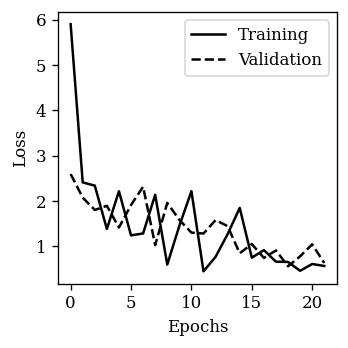

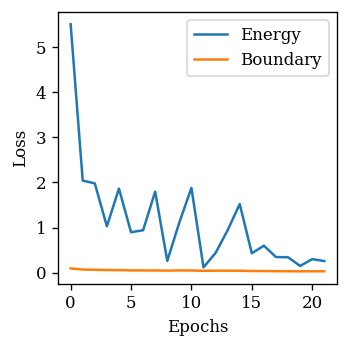

In [104]:
# Plot loss 
matplotlib.rcParams["font.family"] = "serif"
plt.figure(dpi=120, figsize=[3,3])
plt.plot(model.hist.history['loss'], label='Training', linestyle='solid', color='k')
plt.plot(model.hist.history['val_loss'], label='Validation', linestyle='dashed', color='k')
plt.xlabel('Epochs'), plt.ylabel('Loss')
# plt.ylim(0, 4)
plt.legend()

plt.figure(dpi=120, figsize=[3,3])
plt.plot(np.array(model.hist.history['energy_loss'])*.1, label='Energy')
plt.plot(np.array(model.hist.history['boundary_loss'])*.9, label='Boundary')
# plt.plot(np.multiply(model.hist.history['divergence_loss'], 1e3), label='Divergence')
plt.xlabel('Epochs'), plt.ylabel('Loss')
# plt.ylim(0, 4)
plt.legend()

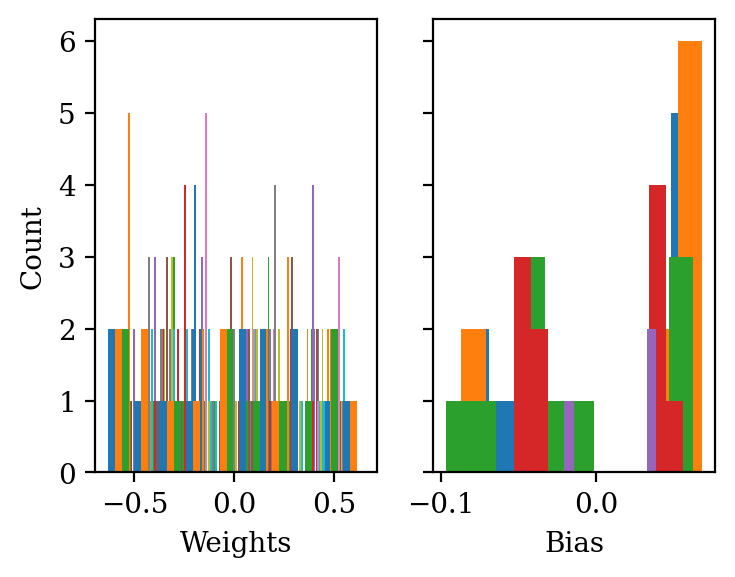

In [105]:
# Visualize weights
fig, ax = plt.subplots(1,2, dpi=200, figsize=[4, 3], sharey=True)
for layer in model.net.layers:
    try:
        ax[0].hist(layer.get_weights()[0])
        ax[1].hist(layer.get_weights()[1])
    except:
        0
ax[0].set_xlabel('Weights')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Bias')
plt.savefig('weight_size.png')

In [106]:
# Reference damage law
gamma0 = 0.2
gammaf = 0.4
G12 = 2.6
gamma = model.x_train[:,2]
gamma = np.linspace(0, model.x_train[:,2].max(), 50)
d12 = np.multiply((gamma>=gamma0),np.divide((gamma-gamma0),(gammaf-gamma0)))
tau = G12*gamma - np.multiply(d12*G12, gamma)
tau[gamma>gammaf] = 0

gamma0 = 0.00
gammaf = 0.4
eps_12 = np.linspace(0, 0.22, 100)
gamma = eps_12*2
G12 = 5
d12 = np.multiply((gamma>=gamma0),np.divide((gamma-gamma0),(gammaf-gamma0)))**(1/3)
d12[gamma>gammaf] = 1
tau = np.multiply(G12*(1-d12), gamma)


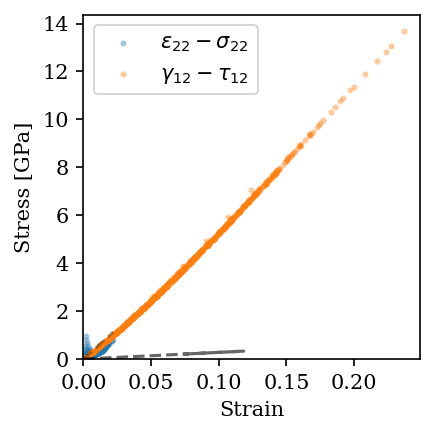

In [107]:
# Plot predicted stress-strain
skip = np.round(model.x_train.shape[0]/1000, decimals=0).astype(int)
# print(model.net.summary())
plt.figure(dpi=150, figsize = [3, 3])
model_s = Model(model.net.get_layer('strains').input, model.net.get_layer('out').output)
S = model_s.predict(test_data.x_train)
gxy = model.x_train[:,2][::skip]
gxy_t = np.linspace(0, gxy.max(), 100)
ex = model.x_train[:,0][::skip]
ex_t = np.linspace(0, ex.max(), 100)
ey = model.x_train[:,1][::skip]
ey_t = np.linspace(0, ey.max(), 100)
E1, E2, v12, v21, G12 = 48, 48, 0.14, 0.14, 2.8

# Plot e1 vs s1
# plt.scatter(model.x_train[::skip, 0], 2*S[::skip, 0, 0], s=4, alpha=0.3, label='$\\varepsilon_{11} - \sigma_{11}$')
# plt.plot(ex_t, E1*ex_t+v12*E2*ey_t, linestyle='--', alpha=.6, color='black', label='Reference')

# Plot e2 vs s2
plt.scatter(model.x_train[::skip, 1]/10, 10*S[::skip, 0, 1], s=4, alpha=0.3, label='$\\varepsilon_{22} - \sigma_{22}$')
plt.plot(ey_t/10, (E2*ey_t+v21*E1*ex_t)/10, linestyle='--', alpha=.3, color='black')

# Plot gamma12 vs tau12
plt.scatter(2*model.x_train[::skip, 2]/10, 10*S[::skip, 0, 2], s=4, alpha=0.3, label='$\\gamma_{12} - \\tau_{12}$')
# plt.plot(gamma, tau, linestyle='--', alpha=.6, color='black')
plt.plot(gxy/10, G12*gxy/10, linestyle='--', alpha=.6, color='black')

plt.xlabel('Strain'), plt.ylabel('Stress [GPa]')
plt.xlim(0,),plt.ylim(0,)
plt.legend()
plt.tight_layout()
plt.savefig('Stress_strain_{}deg.png'.format(15), dpi=300)

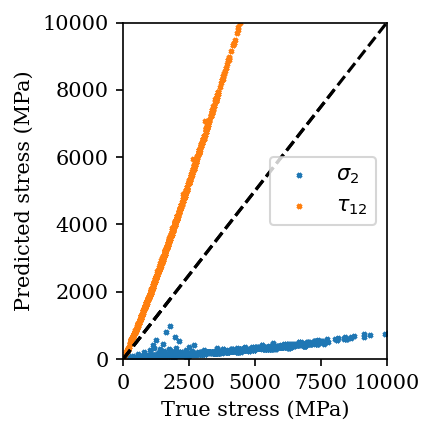

In [137]:
plt.figure(dpi=150, figsize = [3, 3])
d12 = np.multiply((gxy>=gamma0),np.divide((gxy-gamma0),(gammaf-gamma0)))
tau = G12*gxy - np.multiply(d12*G12, gxy)
tau[gxy>gammaf] = 0
# plt.scatter(1e3*(E1*ex+v12*E2*ey)/(1-0.14**2), S[::skip, 0, 0]*1e4, marker='x', s=4, label='$\sigma_1$')
plt.scatter(1e3*(v12*E1*ex+E2*ey)/(1-0.14**2), 10*S[::skip, 0, 1]*1e3, marker='x', s=4, label='$\sigma_2$')
plt.scatter((2*gxy)*(2.5)*1e3, 10*S[::skip, 0, 2]*1e3, marker='x', s=4, label='$\\tau_{12}$')
plt.plot([0, 1800], [0, 1800], linestyle='--', color='black')
plt.plot([0, 0.8*10000], [0, 10000*0.8], linestyle='--', color='black')
plt.plot([0, 1.2*10000], [0, 10000*1.2], linestyle='--', color='black')
plt.xlim(0, 10000), plt.ylim(0, 10000)
plt.xlabel('True stress (MPa)')
plt.ylabel('Predicted stress (MPa)')
plt.legend()
plt.tight_layout()
# plt.savefig('Stress_accuracyplot_{}deg.png'.format(15, dpi=300)

(140000,)


((0.0, 57.75), (0.0, 1231.4877543668233), None)

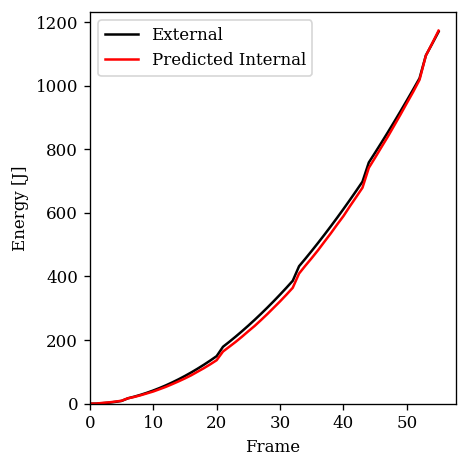

In [109]:
plt.figure(dpi=120, figsize=[4, 4])
eni_pred = np.multiply(model.x_train, np.squeeze(S)).sum(axis=1)
eni_pred_comp = np.multiply(model.x_train, np.squeeze(S))
print(eni_pred.shape)
plt.plot(model.y_train[::test_data.nelem], linestyle='solid', color='black', label='External')
plt.plot(eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='solid', color='red', label='Predicted Internal')
plt.xlabel('Frame'), plt.ylabel('Energy [J]')
plt.legend()
plt.xlim(0), plt.ylim(0), plt.tight_layout()
# plt.savefig('internal_energy_45deg.png', dpi=300)

<ipython-input-110-3c76ad47773b>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eni_pred_comp[:, 0].reshape((-1, test_data.nelem)).sum(axis=1)/eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='solid', color='k',label='$x$')
<ipython-input-110-3c76ad47773b>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eni_pred_comp[:, 1].reshape((-1, test_data.nelem)).sum(axis=1)/eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='solid', color='r', label='$y$')
<ipython-input-110-3c76ad47773b>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(eni_pred_comp[:, 2].reshape((-1, test_data.nelem)).sum(axis=1)/eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='dashed', color='k', label='$xy$')


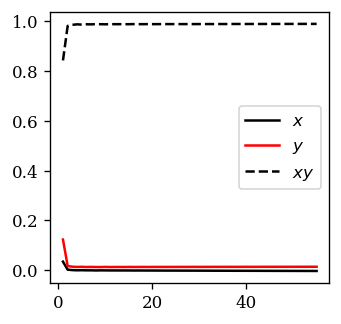

In [110]:
plt.figure(dpi=120, figsize=[3, 3])
plt.plot(eni_pred_comp[:, 0].reshape((-1, test_data.nelem)).sum(axis=1)/eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='solid', color='k',label='$x$')
plt.plot(eni_pred_comp[:, 1].reshape((-1, test_data.nelem)).sum(axis=1)/eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='solid', color='r', label='$y$')
plt.plot(eni_pred_comp[:, 2].reshape((-1, test_data.nelem)).sum(axis=1)/eni_pred.reshape((-1, test_data.nelem)).sum(axis=1), linestyle='dashed', color='k', label='$xy$')
plt.legend()

# plt.plot([0, 7000], [0, 7000], linestyle='dashed', linewidth=0.5, color='k')
# plt.scatter(model.y_train[::test_data.nelem], eni_pred.reshape((-1, test_data.nelem)).sum(axis=1),
#            marker='.', color='k', s=4)
# plt.axis('equal')

In [119]:
model.net.summary()
model_Ctr = Model(model.net.get_layer('strains').input, model.net.get_layer('trCa').output)
model_Cdev = Model(model.net.get_layer('strains').input, model.net.get_layer('devC').output)
Ctr = model_Ctr.predict(model.x_train)
Cdev = model_Cdev.predict(model.x_train)
print(C[:, :, 2])
plt.figure(dpi=100, figsize=[3,3])
# plt.scatter(model.x_train[:, 0][::skip], C[:, :, 0][::skip], marker='.', label='$E_1/(1-\\nu_{12}^2)$')
# plt.scatter(model.x_train[:, 0][::skip], C[:, :, 0][::skip], marker='.',label='$E_2/(1-\\nu_{12}^2)$')
# plt.scatter(model.x_train[:, 1][::skip], C[:, :, 2][::skip], marker='.',label='$\\nu_{12}E_2/(1-\\nu_{12}^2)$')

plt.scatter(model.x_train[:, 2][::skip]*1e1, 1e1*Cdev[:, :, 0][::skip]/2, marker='.',label='$G_{12}/(1-\\nu_{12}^2)$')
plt.legend()
plt.figure(dpi=100, figsize=[3,3])
plt.scatter(model.x_train[:, 1][::skip]*1e1, 1e1*Ctr[:, :, 2][::skip], marker='.', label='$E_1/(1-\\nu_{12}^2)$')
plt.legend()

Model: "model_332380"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
strains (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 1, 3)         0           strains[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 1, 10)        40          reshape_7[0][0]                  
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 1, 10)        110         dense_28[0][0]                   
_______________________________________________________________________________________

ValueError: No such layer: devC.